In [1]:
import argparse
import cvxpy as cp
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from pydmd import DMDc

device = "cuda"

In [2]:
# distribution parameters need to be fixed for the simulation
mu_m_B, sigma_m_B = np.random.random(), np.abs(np.random.random())
mu_m_L, sigma_m_L = np.random.random(), np.abs(np.random.random())
mu_d_L, sigma_d_L = np.random.random(), np.abs(np.random.random())
mu_k_B, sigma_k_B = np.random.random(), np.abs(np.random.random())
mu_d_B, sigma_d_B = np.random.random(), np.abs(np.random.random())

In [3]:
np.abs(np.random.normal(mu_m_B, sigma_m_B, 10)).shape

(10,)

In [4]:
m_L = np.expand_dims(np.abs(np.random.normal(mu_m_L, sigma_m_L, 3)),axis=0)
m_B = np.expand_dims(np.abs(np.random.normal(mu_m_B, sigma_m_B, 3)),axis=0)
np.vstack([m_B, m_L]).T.shape

(3, 2)

In [5]:
def generate_dynamics_matrices(num_samples):
    m_B = np.expand_dims(np.abs(np.random.normal(mu_m_B, sigma_m_B, num_samples)),axis=0)
    m_L = np.expand_dims(np.abs(np.random.normal(mu_m_L, sigma_m_L, num_samples)),axis=0)
    d_L = np.expand_dims(np.abs(np.random.normal(mu_d_L, sigma_d_L, num_samples)),axis=0)
    k_B = np.expand_dims(np.abs(np.random.normal(mu_k_B, sigma_k_B, num_samples)),axis=0)
    d_B = np.expand_dims(np.abs(np.random.normal(mu_d_B, sigma_d_B, num_samples)),axis=0)
    
    thetas = np.vstack([m_B, m_L, d_L, k_B, d_B]).T
    As = np.zeros((num_samples, 4, 4))
    As[:,0,1]  = 1

    As[:,1,1] = -d_L / m_L - d_L / m_B 
    As[:,1,2] = k_B / m_B
    As[:,1,3] = d_B / m_B 

    As[:,2,3] = 1

    As[:,3,1] = d_L / m_B
    As[:,3,2] = -k_B / m_B
    As[:,3,3] = -d_B / m_B

    Bs = np.zeros((num_samples, 4, 1))
    Bs[:,1,0] = 1 / m_L + 1 / m_B
    Bs[:,3,0] = -1 / m_B

    return thetas, (As, Bs)

In [6]:
# m: trajectory length
def generate_system_trajectories(As, Bs, m = 25):
    n = As.shape[-1]
    l = Bs.shape[-1]

    x0 = np.random.random((n, 1))
    u = np.random.rand(l, m - 1) - .5

    x0 = np.tile(x0, reps=(As.shape[0],1,1)).astype(np.float32)
    u  = np.tile(u,  reps=(Bs.shape[0],1,1)).astype(np.float32)

    snapshots = [x0]

    for i in range(m - 1):
        snapshots.append(As @ snapshots[i] + Bs @ u[:, :, i:i+1])
    snapshots = np.array(snapshots).T
    return {'snapshots': snapshots, 'u': u, 'B': Bs, 'A': As}

In [7]:
def estimate_dynamics_matrices(system):
    mb_size = system["A"].shape[0]
    A_hats, B_hats = [], []
    for i in range(mb_size):
        dmdc = DMDc(svd_rank=-1, opt=True)
        dmdc.fit(system['snapshots'][:,:,i,:], system['u'][i])
        A_hat, B_hat, _ = dmdc.reconstructed_data() # NOTE: the PyDMD reconstructed_data() function was modified to return the dynamics -- this will *not* work by default
        A_hats.append(np.real(A_hat))
        B_hats.append(np.real(B_hat))
    A_hats = np.array(A_hats).reshape(mb_size, -1)
    B_hats = np.array(B_hats).reshape(mb_size, -1)
    return A_hats, B_hats

In [8]:
def generate_data(n_pts):
    thetas, (As, Bs) = generate_dynamics_matrices(n_pts)
    system = generate_system_trajectories(As, Bs, m = 25)
    A_hats, B_hats = estimate_dynamics_matrices(system)
    A_hats, B_hats = A_hats.reshape(As.shape), B_hats.reshape(Bs.shape)

    thresh    = 0.1
    valid_ind = np.where(np.logical_and(
        np.linalg.norm(A_hats - As, ord="fro", axis=(1,2)) < thresh,
        np.linalg.norm(B_hats - Bs, ord="fro", axis=(1,2)) < thresh,
    ))
    thetas, As, Bs, A_hats, B_hats = thetas[valid_ind], As[valid_ind], Bs[valid_ind], A_hats[valid_ind], B_hats[valid_ind]

    thetas         = torch.from_numpy(thetas).to(torch.float32).to(device)
    As, Bs         = torch.from_numpy(As).to(torch.float32).to(device), torch.from_numpy(Bs).to(torch.float32).to(device)
    A_hats, B_hats = torch.from_numpy(A_hats).to(torch.float32).to(device), torch.from_numpy(B_hats).to(torch.float32).to(device)

    return thetas, (As, Bs), (A_hats, B_hats)

In [9]:
class ContextualLQR(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        
        self.fc_A = nn.Linear(64, 16)
        self.fc_B = nn.Linear(64, 4)
        self.fc_C = nn.Linear(64, 24)

    def forward(self, theta):
        x = F.relu(self.fc1(theta))
        
        fc2_x = self.fc2(x)
        x     = F.relu(x + fc2_x)

        fc3_x = self.fc3(x)
        x     = F.relu(x + fc3_x)

        # for predictions of A matrix
        A = self.fc_A(x).reshape((-1,4,4))

        # for predictions of B matrix
        B = self.fc_B(x).reshape((-1,4,1))

        # for predictions of C := [A, B] matrix
        # C = self.fc_C(x).reshape((-1,4,6))
        # return C
        return A, B

In [10]:
import torch.optim as optim

net       = ContextualLQR().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.MSELoss()

N_train = 500
thetas_train, _, (As_train, Bs_train) = generate_data(N_train)

/home/yppatel/anaconda3/envs/operator/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 4204965772700907.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/yppatel/anaconda3/envs/operator/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 3849679.6802446805. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/yppatel/anaconda3/envs/operator/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 17660239717608.03. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/yppatel/anaconda3/envs/operator/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 67486432.07023917. Consider preprocessing data, passing in augmented data
matrix, or regularizat

In [11]:
epochs      = 5_000
batch_size  = 500
num_batches = N_train // batch_size

losses = []
for epoch in range(epochs):  # loop over the dataset multiple times
    rolling_loss = 0
    for i in range(num_batches):
        optimizer.zero_grad()

        theta_batch, (A_batch, B_batch) = thetas_train[i*batch_size:(i+1)*batch_size], (As_train[i*batch_size:(i+1)*batch_size], Bs_train[i*batch_size:(i+1)*batch_size])
        A_hat_batch, B_hat_batch = net(theta_batch)
        
        loss = criterion(A_hat_batch, A_batch) + criterion(B_hat_batch, B_batch)
        
        loss.backward()
        optimizer.step()

        rolling_loss += loss.item()
    losses.append(rolling_loss)
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {rolling_loss}')
print('Finished Training')

[1,     1] loss: 18.77172088623047
[2,     1] loss: 18.498838424682617
[3,     1] loss: 18.23807144165039
[4,     1] loss: 17.986616134643555
[5,     1] loss: 17.740882873535156
[6,     1] loss: 17.499446868896484
[7,     1] loss: 17.261913299560547
[8,     1] loss: 17.027006149291992
[9,     1] loss: 16.79168128967285
[10,     1] loss: 16.55467414855957
[11,     1] loss: 16.315025329589844
[12,     1] loss: 16.073326110839844
[13,     1] loss: 15.828147888183594
[14,     1] loss: 15.576333045959473
[15,     1] loss: 15.316561698913574
[16,     1] loss: 15.048047065734863
[17,     1] loss: 14.770852088928223
[18,     1] loss: 14.485342025756836
[19,     1] loss: 14.191618919372559
[20,     1] loss: 13.890378952026367
[21,     1] loss: 13.58281135559082
[22,     1] loss: 13.270419120788574
[23,     1] loss: 12.955557823181152
[24,     1] loss: 12.640838623046875
[25,     1] loss: 12.328874588012695
[26,     1] loss: 12.023726463317871
[27,     1] loss: 11.730605125427246
[28,     1] los

In [27]:
def generate_scores(net, num_samples, get_true_dynamics=False):
    if get_true_dynamics:
        xs, (As, Bs), _ = generate_data(num_samples)
    else:
        xs, _, (As, Bs) = generate_data(num_samples)
    A_hat, B_hat = net(xs)

    C = torch.cat([As, Bs], axis=-1).cpu().detach().numpy()
    C_hat = torch.cat([A_hat, B_hat], axis=-1).cpu().detach().numpy()
    diff = C - C_hat
    return (C, C_hat), np.linalg.norm(diff, ord=2, axis=(1,2))

In [30]:
N_cal, N_test = 200, 200
(cal_C, cal_C_hat),   cal_scores  = generate_scores(net, num_samples=N_cal,  get_true_dynamics=False)
(test_C, test_C_hat), test_scores = generate_scores(net, num_samples=N_test, get_true_dynamics=True)
N_cal, N_test = len(cal_C), len(test_C)

/home/yppatel/anaconda3/envs/operator/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 7675289.1869149. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/yppatel/anaconda3/envs/operator/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 2958523162.5911446. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/yppatel/anaconda3/envs/operator/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 2235614453418.448. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/yppatel/anaconda3/envs/operator/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 6.044427895294081e+19. Consider preprocessing data, passing in augmented data
matrix, or regulariza

Text(0.5, 1.0, '$\\mathrm{Model\\ Calibration}$')

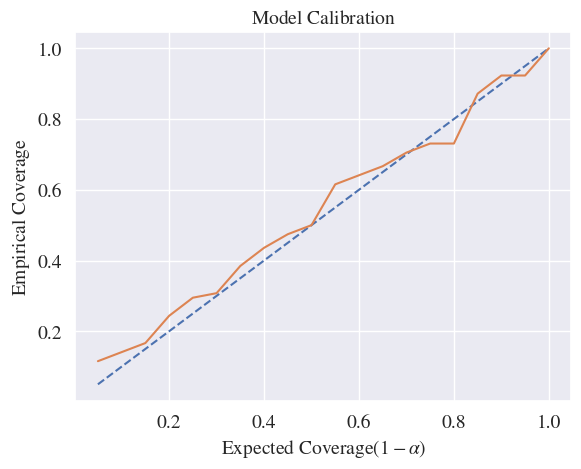

In [31]:
sns.set_theme()

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

alphas = np.arange(0, 1, 0.05)
coverages = []
for alpha in alphas:
    q_hat = np.quantile(cal_scores, q = 1-alpha)
    coverages.append(np.sum(test_scores < q_hat) / N_test)

sns.lineplot(x=(1-alphas), y=(1-alphas), linestyle='--')
sns.lineplot(x=(1-alphas), y=coverages)
plt.xlabel(r"$\mathrm{Expected\ Coverage} (1-\alpha)$")
plt.ylabel(r"$\mathrm{Empirical\ Coverage}$")
plt.title(r"$\mathrm{Model\ Calibration}$")

In [32]:
alpha = 0.05
q_hat = np.quantile(cal_scores, q = 1-alpha)

with open("experiments/load_pos.pkl", "wb") as f:
    pickle.dump({
        "test_C": test_C, 
        "test_C_hat": test_C_hat,
        "q_hat": q_hat,
    }, f)